In [1]:
import os
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
subset_train = pq.read_pandas("/home/jeffrey/repos/VSB_Power_Line_Fault_Detection/source_data/train.parquet", columns=[str(i) for i in range(9)]).to_pandas()

Text(0, 0.5, 'Amplitude [bit]')

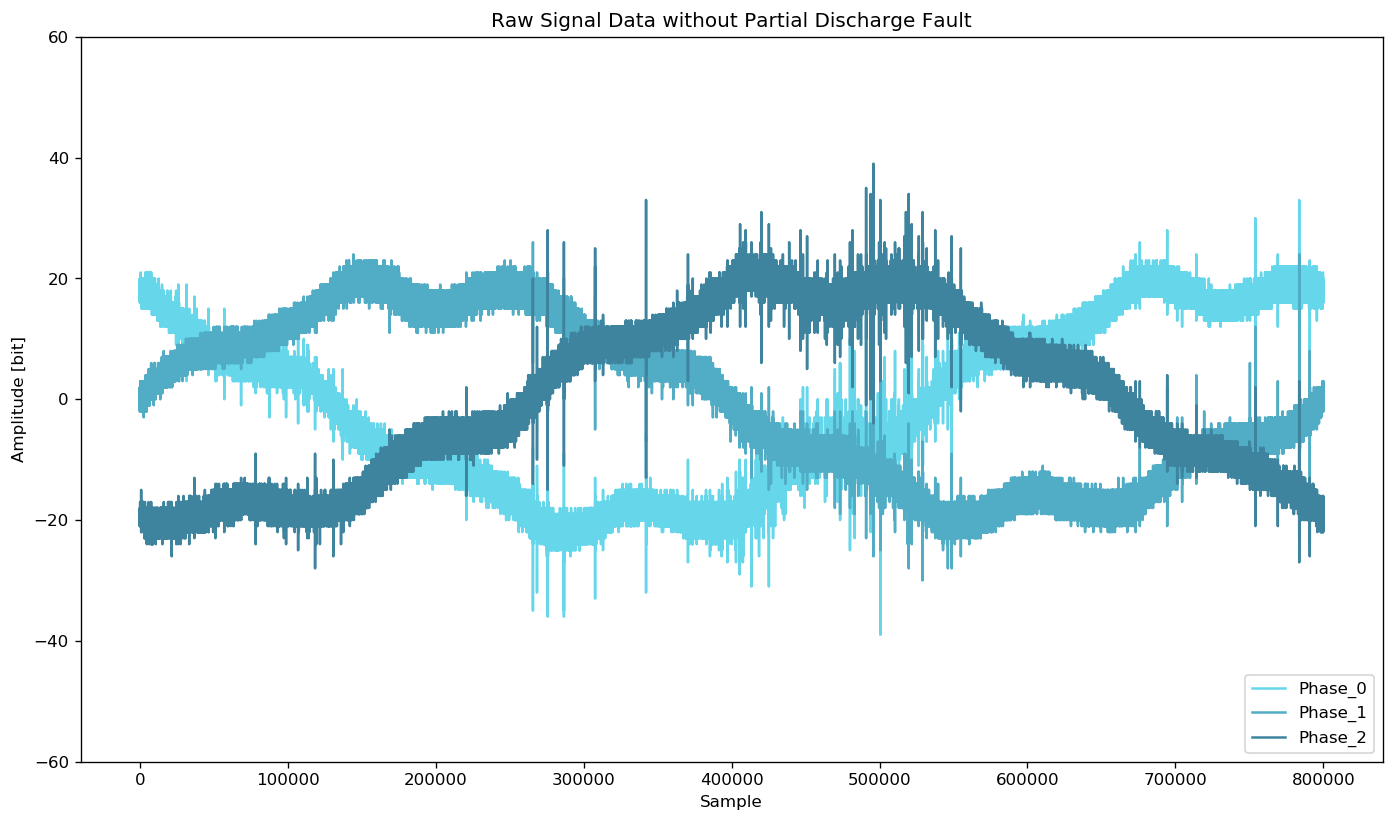

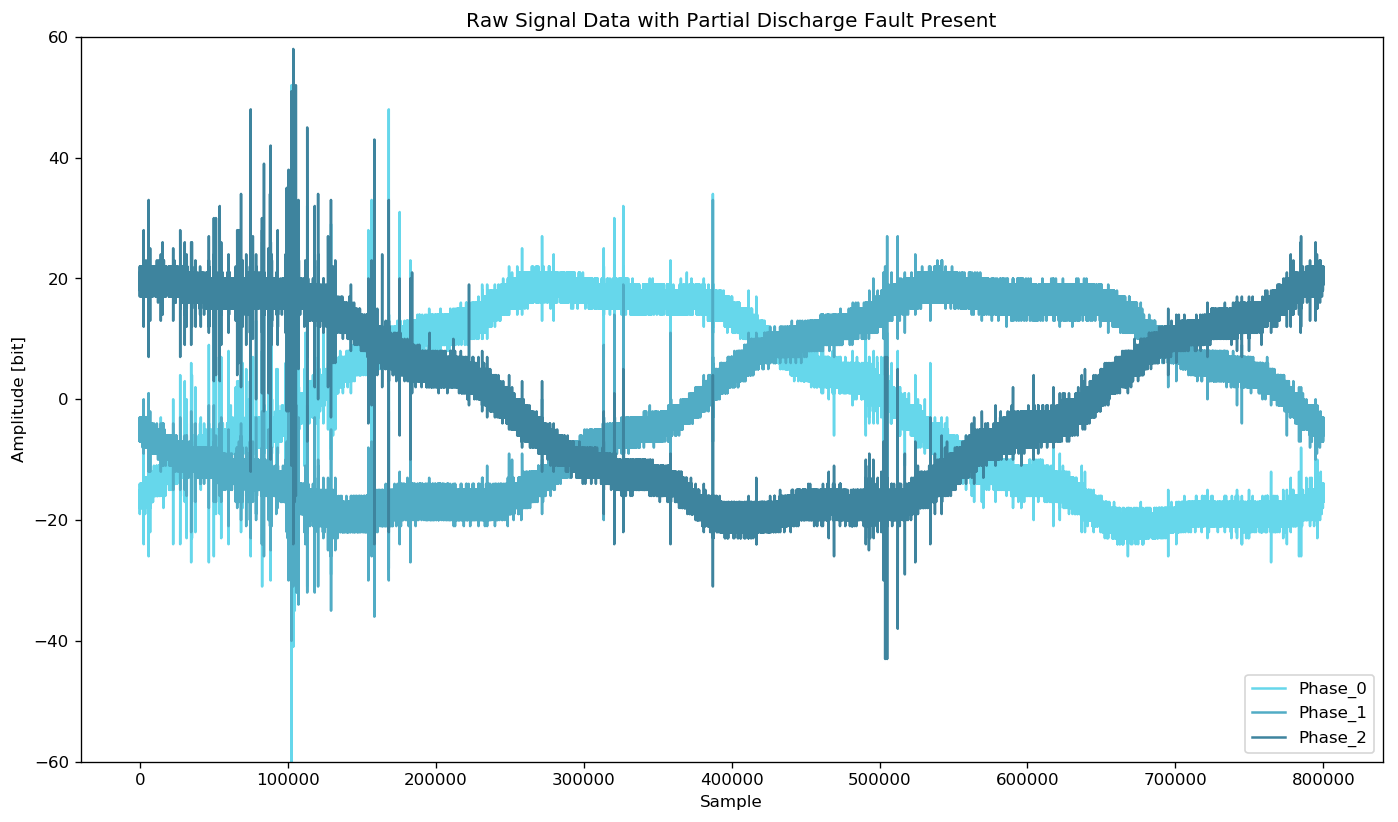

In [3]:
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(subset_train))), subset_train["0"], '-', label=plot_labels[0], color=blues[0])
plt.plot(list(range(len(subset_train))), subset_train["1"], '-', label=plot_labels[1], color=blues[1])
plt.plot(list(range(len(subset_train))), subset_train["2"], '-', label=plot_labels[2], color=blues[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Signal Data without Partial Discharge Fault')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(subset_train))), subset_train["3"], '-', label=plot_labels[0], color=blues[0])
plt.plot(list(range(len(subset_train))), subset_train["4"], '-', label=plot_labels[1], color=blues[1])
plt.plot(list(range(len(subset_train))), subset_train["5"], '-', label=plot_labels[2], color=blues[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Signal Data with Partial Discharge Fault Present')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

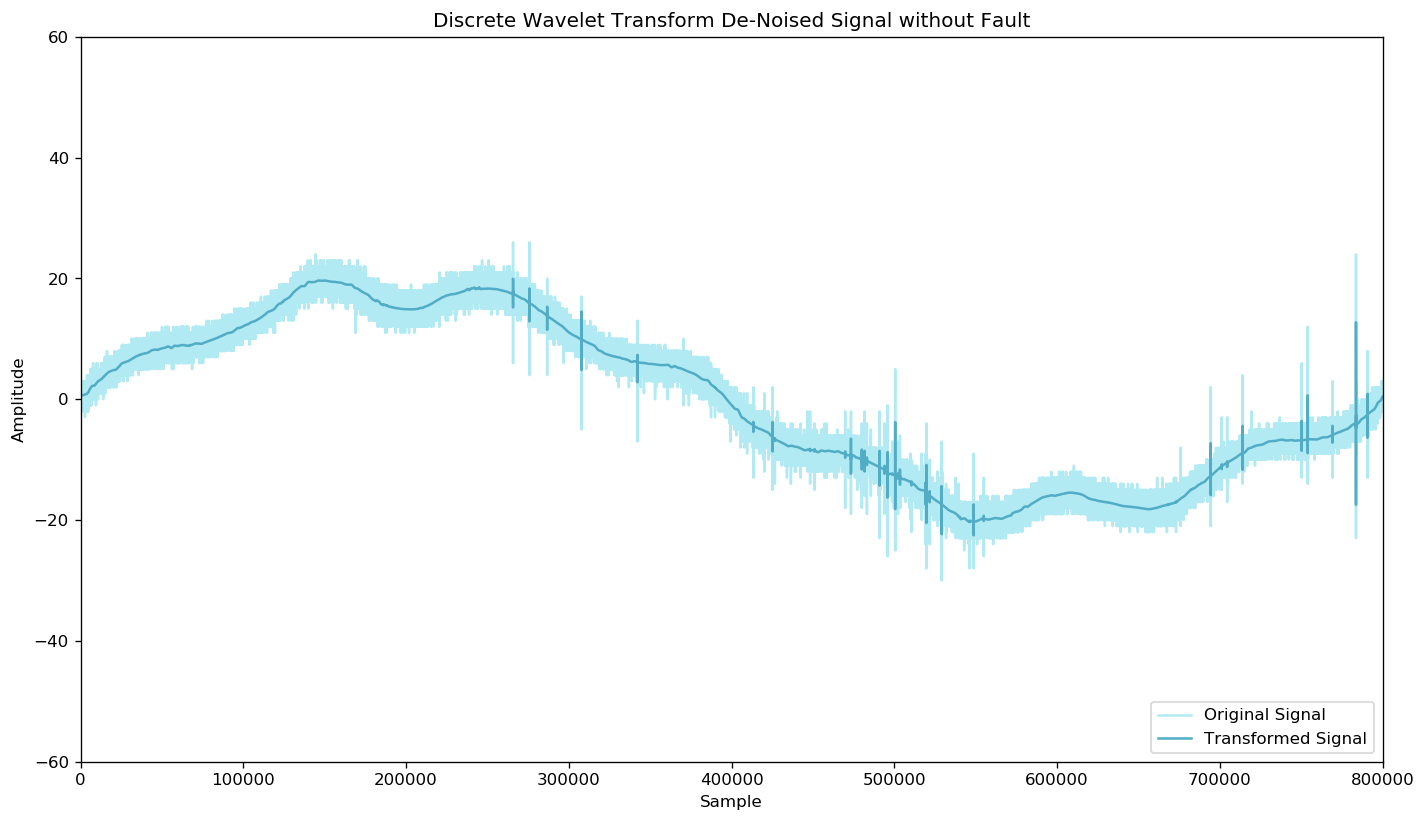

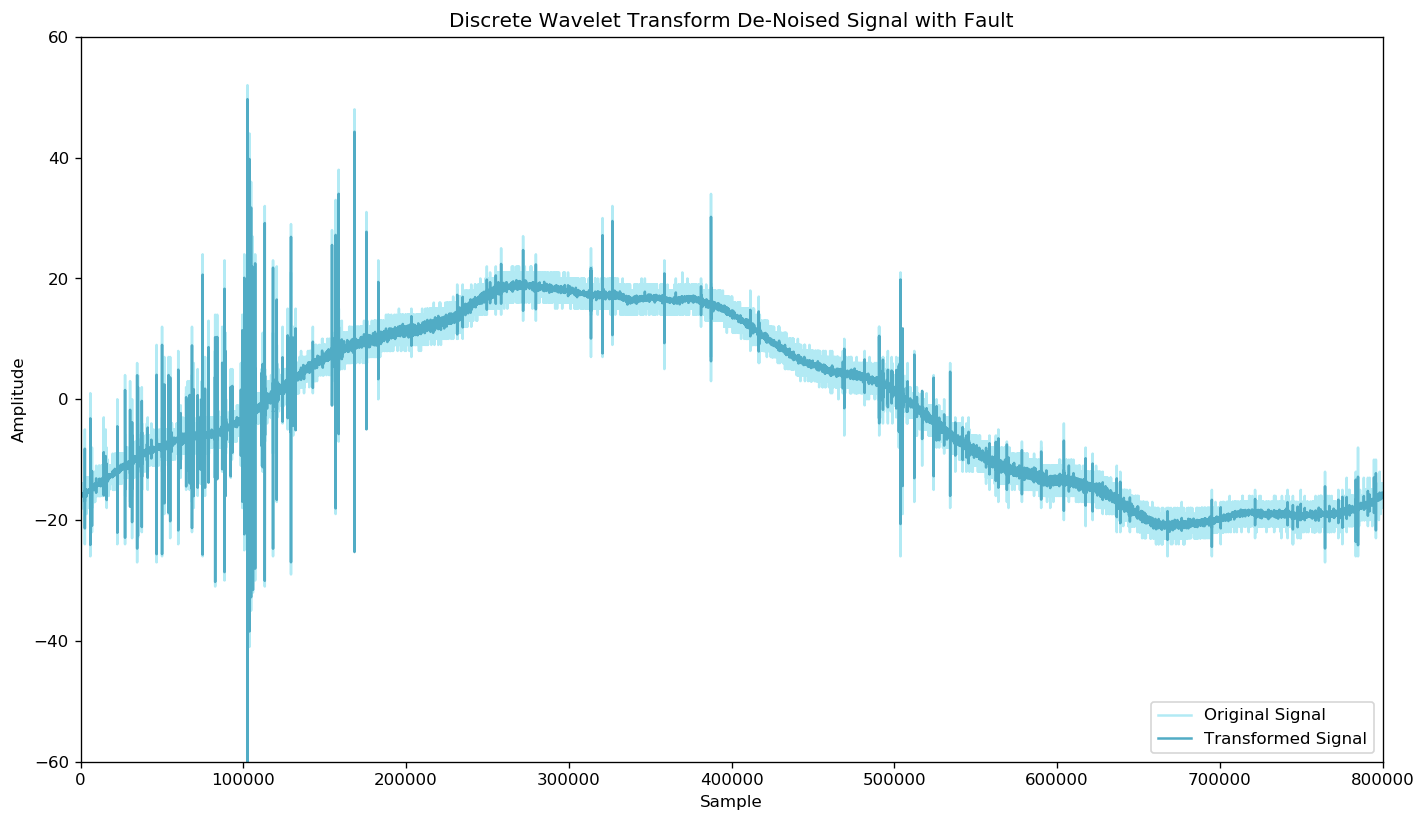

In [4]:
import pywt
from statsmodels.robust import mad
from scipy import signal
 
def waveletSmooth( x, wavelet="db4", level=1, title=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    plt.plot( x, color="#66D7EB", alpha=0.5, label="Original Signal")
    plt.plot( y, color="#51ACC5", label="Transformed Signal" )
    plt.ylim((-60, 60))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(y)))
    return y
title0 = 'Discrete Wavelet Transform De-Noised Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised Signal with Fault'
signal_0 =  waveletSmooth(subset_train["1"], wavelet="db4", level=1, title=title0 )
signal_1 =  waveletSmooth(subset_train["3"], wavelet="db4", level=1, title=title1 )

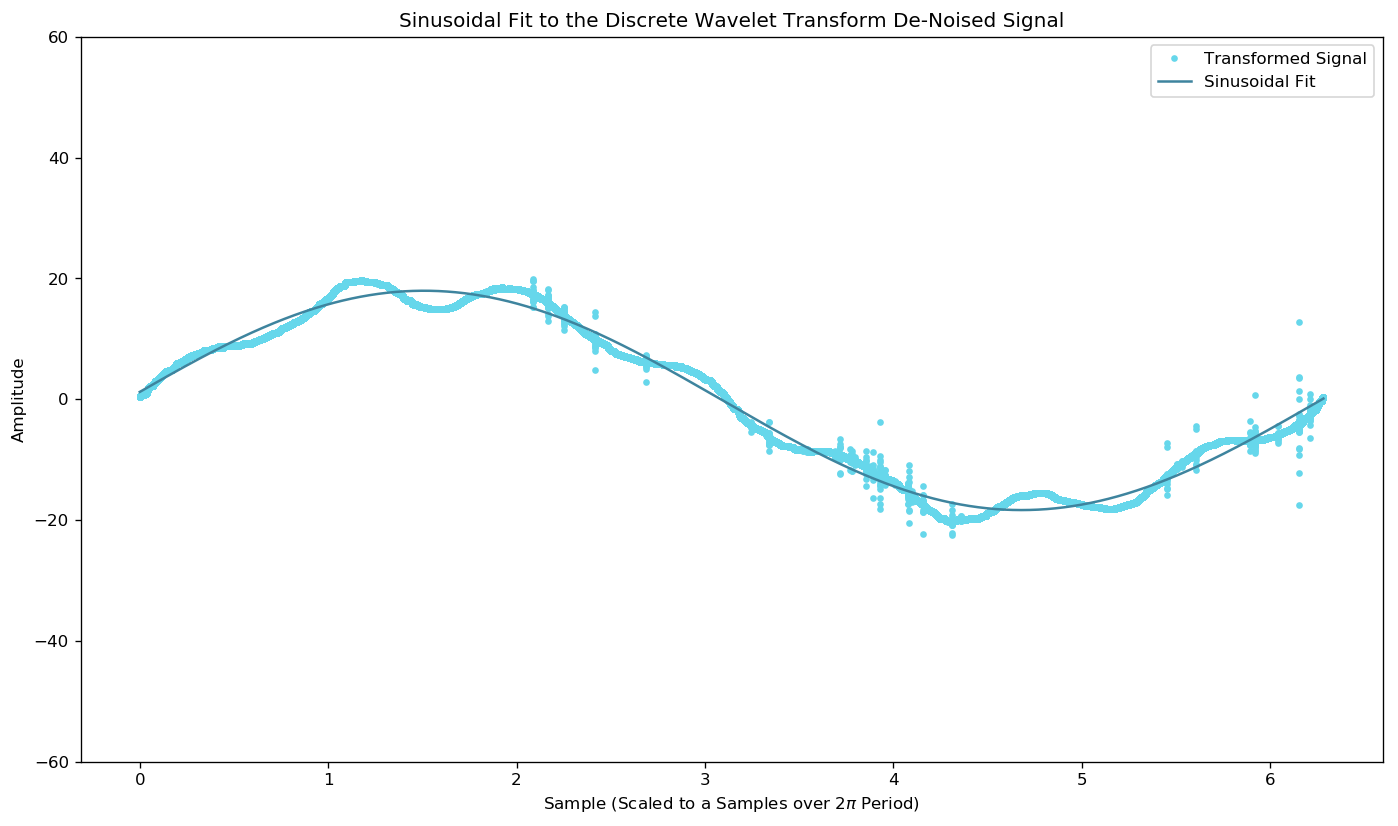

In [38]:
from scipy.optimize import leastsq

def fit_sinusoid(signal):
    t = np.linspace(0, 2*np.pi, len(signal))  # data covers one period
    guess_mean = np.mean(signal)
    guess_std = 3*np.std(signal)/(2**0.5)/(2**0.5)
    guess_phase = 0
    guess_freq = 1
    guess_amp = 1

    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - data
    est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

    # recreate the fitted curve using the optimized parameters
    signal_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean

    # recreate the fitted curve using the optimized parameters
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot(t, signal, '.', color=blues[0], label="Transformed Signal")
    plt.plot(t, signal_fit, label="Sinusoidal Fit", color=blues[2])
    plt.xlabel(r"Sample (Scaled to a Samples over 2$\pi$ Period)")
    plt.ylabel("Amplitude")
    plt.ylim((-60, 60))
    plt.title("Sinusoidal Fit to the Discrete Wavelet Transform De-Noised Signal")
    plt.legend()
    plt.show()
    return signal_fit

signal_fit0 = fit_sinusoid(signal_0)

In [39]:
slope = np.gradient(signal_fit0)

def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

high_prob_region = find_indices(slope, lambda e: e>0)

Text(0.5, 1.0, 'Sinusoidal Fit with PD Probable Region Highlighted with the De-Noised Signal')

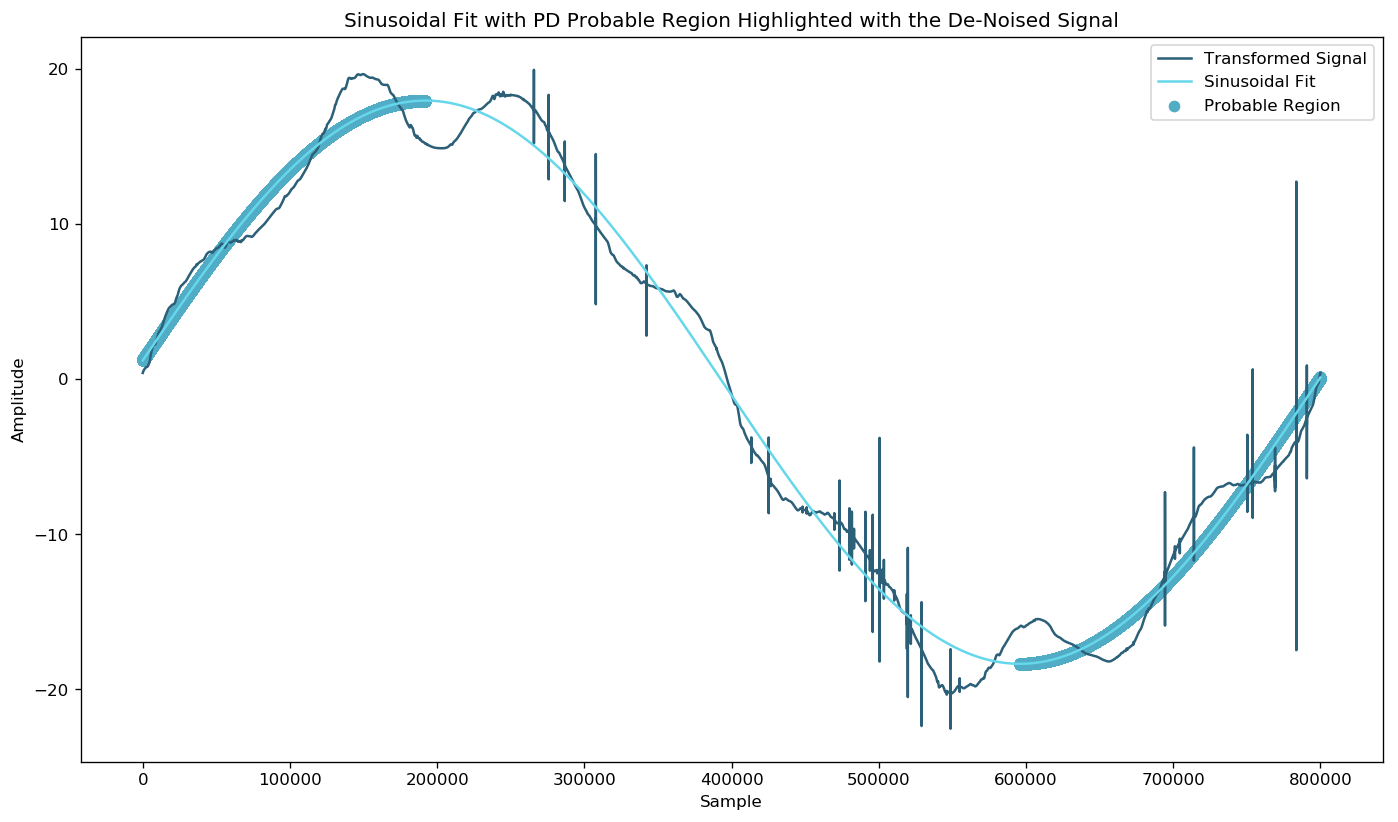

In [40]:
f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(data, color=blues[3], label="Transformed Signal")
plt.plot(data_fit, color=blues[0], label="Sinusoidal Fit")
plt.scatter(high_prob_region, data_fit[high_prob_region], color=blues[1], label="Probable Region")
plt.legend()
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.title("Sinusoidal Fit with PD Probable Region Highlighted with the De-Noised Signal")

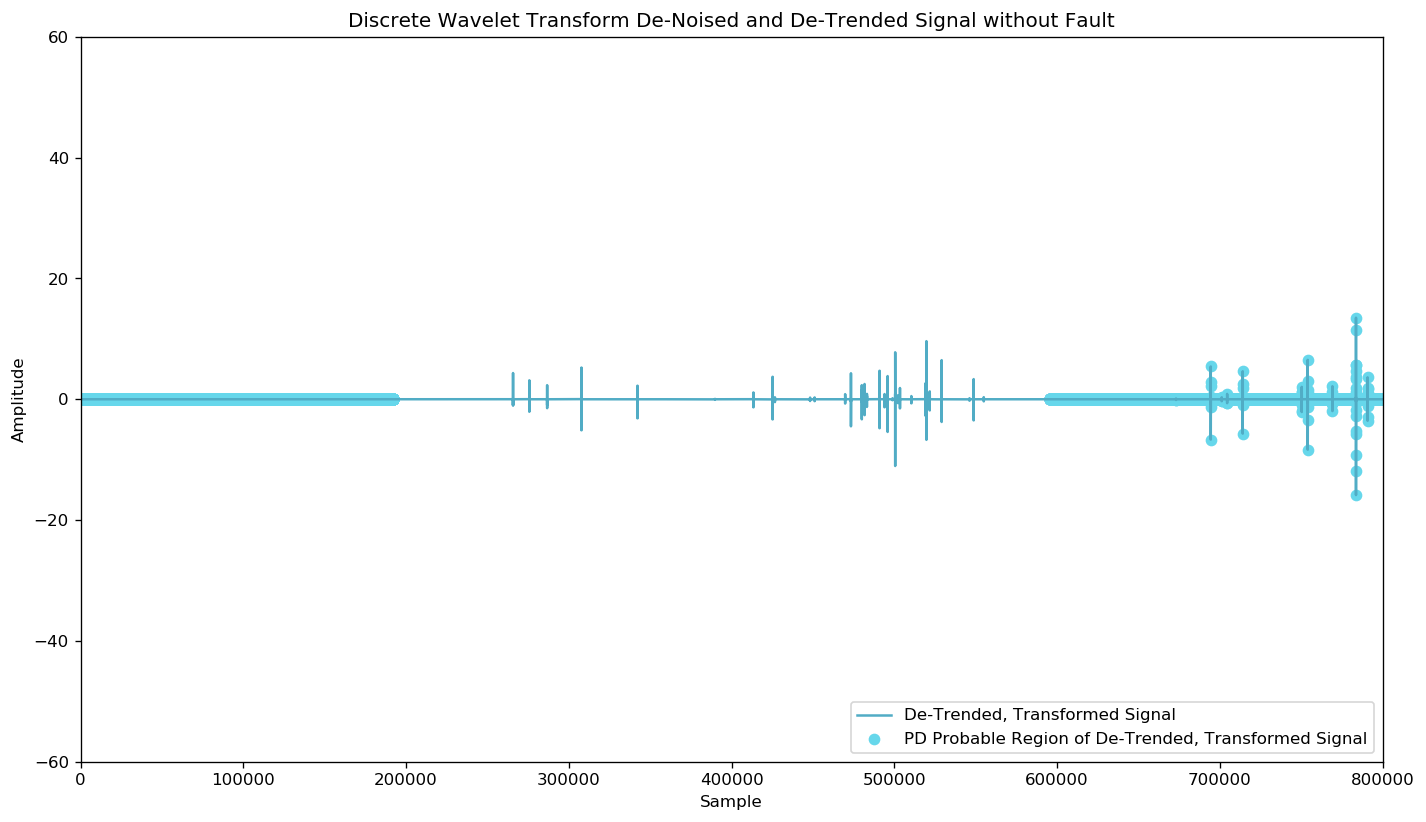

In [31]:
import pywt
from statsmodels.robust import mad
from scipy import signal
 
def detrend_signal( signal, high_prob_idx, title=None ):
    
    x = np.diff(signal, n=1)
    if max(high_prob_idx) == len(x):
        high_prob_idx = high_prob_idx[0:-1]
        
    
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    plt.plot( x, color=blues[1], label="De-Trended, Transformed Signal")
    plt.scatter(high_prob_idx, x[high_prob_idx], color=blues[0], label="PD Probable Region of De-Trended, Transformed Signal" )
    plt.ylim((-60, 60))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(x)))
    return x[high_prob_idx]


title0 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal with Fault'
signal_0hp =  detrend_signal(data, high_prob_region, title0)

Text(0.5, 1.0, 'PD Probable Region of De-Trended, Transformed Signal')

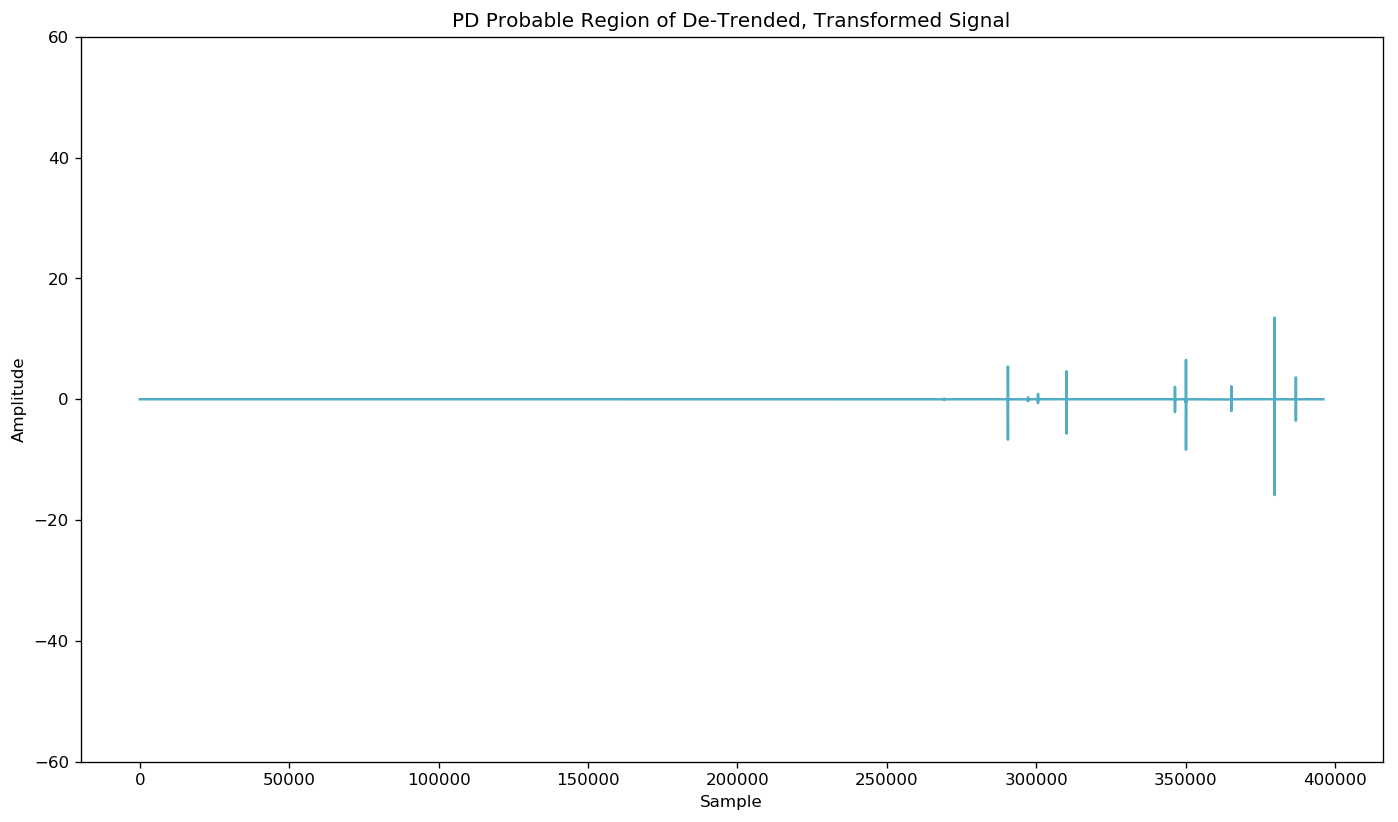

In [34]:
f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(signal_0hp, color=blues[1])
plt.ylim((-60, 60))
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("PD Probable Region of De-Trended, Transformed Signal")